# Stocks Price Prediction

In [52]:
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
# function to download and save the raw data
def get_data(ticker, start, end):
    raw_data = yf.download(ticker, start, end)
    os.makedirs(f"../datasets/{ticker}", exist_ok=True)
    raw_data.to_csv(f"../datasets/{ticker}/raw.csv")
    return raw_data

In [54]:
ticker = "GOOG"
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)
print(start)

2015-09-09 00:00:00


In [55]:
# downloading the data
raw_data = get_data(ticker, start, end)
raw_data.head()

/tmp/ipykernel_16703/1084484216.py:3: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2015-09-09,30.427774,31.113085,30.272835,30.849887,34042000
2015-09-10,30.856340,30.995886,30.363713,30.446646,38106000
2015-09-11,31.075840,31.076336,30.661178,30.776885,27470000
2015-09-14,30.950201,31.080309,30.760996,31.072364,34046000
2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000


In [56]:
# quick clean up
def clean_up(data):
    clean_data = data.copy()
    clean_data.columns = clean_data.columns.get_level_values(0)
    clean_data.columns.name = None
    clean_data.to_csv(f"../datasets/{ticker}/clean.csv")

clean_up(raw_data)

In [57]:
data = pd.read_csv(f"../datasets/{ticker}/clean.csv")
data.head(10)

,Date,Close,High,Low,Open,Volume
0,2015-09-09,30.427774,31.113085,30.272835,30.849887,34042000
1,2015-09-10,30.856340,30.995886,30.363713,30.446646,38106000
2,2015-09-11,31.075840,31.076336,30.661178,30.776885,27470000
3,2015-09-14,30.950201,31.080309,30.760996,31.072364,34046000
4,2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000
5,2015-09-16,31.582867,31.680696,31.401110,31.557541,25730000
6,2015-09-17,31.926519,32.323798,31.535196,31.672755,45494000
7,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000
8,2015-09-21,31.556053,31.608196,31.084283,31.504407,35770000
9,2015-09-22,30.922886,31.164234,30.562352,31.136921,51258000


In [58]:
data.shape

(2514, 6)

In [59]:
data.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [60]:
data.duplicated().sum()

np.int64(0)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2514 non-null   object 
 1   Close   2514 non-null   float64
 2   High    2514 non-null   float64
 3   Low     2514 non-null   float64
 4   Open    2514 non-null   float64
 5   Volume  2514 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 118.0+ KB


In [62]:
data.tail(10)

,Date,Close,High,Low,Open,Volume
2504,2025-08-25,208.973221,210.901490,205.766081,206.815146,22788800
2505,2025-08-26,207.764297,208.273852,206.265637,208.183921,23051000
2506,2025-08-27,208.024078,209.382865,206.205696,206.275641,15249000
2507,2025-08-28,212.180344,212.709869,207.414614,207.654390,20915700
2508,2025-08-29,213.339310,215.147691,210.781598,211.081333,24682200
2509,2025-09-02,211.800705,212.179364,206.775198,208.803384,28900100
2510,2025-09-03,230.893631,231.593003,224.918960,226.277746,72250300
2511,2025-09-04,232.452240,232.562142,226.557499,229.949472,32196000
2512,2025-09-05,234.959991,235.919141,232.172490,232.452238,26127700
2513,2025-09-08,234.160004,238.399994,233.729996,235.789993,23104200


In [63]:
data.describe()

,Close,High,Low,Open,Volume
count,2514.000000,2514.000000,2514.000000,2514.000000,2.514000e+03
mean,92.621216,93.580157,91.620770,92.557378,2.956575e+07
std,48.223139,48.760894,47.671241,48.186284,1.417169e+07
min,29.542336,30.044397,29.268709,29.661021,6.809800e+06
25%,52.058875,52.671923,51.346374,52.094503,2.065125e+07
50%,75.555950,77.492695,75.004226,75.737956,2.613900e+07
75%,133.368340,134.884780,131.979342,133.317171,3.409300e+07
max,234.959991,238.399994,233.729996,235.789993,1.330780e+08


In [64]:
data["Date"] = pd.to_datetime(data["Date"])
data.head(10)

,Date,Close,High,Low,Open,Volume
0,2015-09-09,30.427774,31.113085,30.272835,30.849887,34042000
1,2015-09-10,30.856340,30.995886,30.363713,30.446646,38106000
2,2015-09-11,31.075840,31.076336,30.661178,30.776885,27470000
3,2015-09-14,30.950201,31.080309,30.760996,31.072364,34046000
4,2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000
5,2015-09-16,31.582867,31.680696,31.401110,31.557541,25730000
6,2015-09-17,31.926519,32.323798,31.535196,31.672755,45494000
7,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000
8,2015-09-21,31.556053,31.608196,31.084283,31.504407,35770000
9,2015-09-22,30.922886,31.164234,30.562352,31.136921,51258000


In [65]:
# creating subplots
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    row_heights=[0.7, 0.3],
    vertical_spacing=0.2
)

# candle stick chart
fig.add_trace(go.Candlestick(
    x = data["Date"],
    open = data["Open"],
    high = data["High"],
    low = data["Low"],
    close = data["Close"],
    name = "Price"
    ),
    row=1, col=1
)

# volume bars
fig.add_trace(go.Bar(
    x = data["Date"],
    y = data["Volume"],
    name = "volume",
    marker_color="#c1440e",
    opacity=1.0,
    ),
    row=2, col=1
)

# layout
fig.update_layout(
    title = "Candlesticks Chart With Volume",
    xaxis_rangeslider_visible = False,
    xaxis_title="Date",
    yaxis_title="Price",
    yaxis2_title="Volume",
    template="plotly_dark",
    showlegend = False,
    height=900
)

fig.show()

In [66]:
# adding log returns
data["Log_Returns"] = np.log(data["Close"] / data["Close"].shift(1))
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns
0,2015-09-09,30.427774,31.113085,30.272835,30.849887,34042000,NaN
1,2015-09-10,30.856340,30.995886,30.363713,30.446646,38106000,0.013986
2,2015-09-11,31.075840,31.076336,30.661178,30.776885,27470000,0.007088
3,2015-09-14,30.950201,31.080309,30.760996,31.072364,34046000,-0.004051
4,2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000,0.018914
5,2015-09-16,31.582867,31.680696,31.401110,31.557541,25730000,0.001322
6,2015-09-17,31.926519,32.323798,31.535196,31.672755,45494000,0.010822
7,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000,-0.021461
8,2015-09-21,31.556053,31.608196,31.084283,31.504407,35770000,0.009789
9,2015-09-22,30.922886,31.164234,30.562352,31.136921,51258000,-0.020269


In [67]:
data["Log_Returns"].isnull().sum()

np.int64(1)

In [68]:
data.shape

(2514, 7)

In [69]:
data.sample(10)

,Date,Close,High,Low,Open,Volume,Log_Returns
1376,2021-02-26,101.150803,102.846694,100.117870,101.829159,41670000,0.002704
418,2017-05-08,46.397491,46.527848,45.948564,45.991271,26596000,0.007704
2301,2024-10-30,175.372452,182.989110,174.979169,181.615134,49698300,0.028797
1166,2020-04-28,61.264252,63.964769,61.191253,63.958813,59026000,-0.033643
1770,2022-09-20,101.137886,102.468775,100.432713,102.180745,24001700,-0.019643
746,2018-08-24,60.617680,60.667339,59.907986,60.030201,18932000,0.012589
872,2019-02-27,55.423225,55.519066,54.675838,54.971316,19368000,0.000825
660,2018-04-24,50.652370,52.490788,50.186060,52.242487,95206000,-0.045490
724,2018-07-25,62.755547,62.862810,61.535396,61.535396,42556000,0.012438
1158,2020-04-16,62.744125,63.515348,61.708711,63.272015,50362000,0.000792


In [70]:
data = data.dropna()
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns
1,2015-09-10,30.856340,30.995886,30.363713,30.446646,38106000,0.013986
2,2015-09-11,31.075840,31.076336,30.661178,30.776885,27470000,0.007088
3,2015-09-14,30.950201,31.080309,30.760996,31.072364,34046000,-0.004051
4,2015-09-15,31.541155,31.717945,30.977015,31.122022,41688000,0.018914
5,2015-09-16,31.582867,31.680696,31.401110,31.557541,25730000,0.001322
6,2015-09-17,31.926519,32.323798,31.535196,31.672755,45494000,0.010822
7,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000,-0.021461
8,2015-09-21,31.556053,31.608196,31.084283,31.504407,35770000,0.009789
9,2015-09-22,30.922886,31.164234,30.562352,31.136921,51258000,-0.020269
10,2015-09-23,30.906500,31.232768,30.789302,30.891106,29418000,-0.000530


In [71]:
data.shape

(2513, 7)

In [72]:
stats = data["Log_Returns"].describe()
skewness = data["Log_Returns"].skew()
kurtosis = data["Log_Returns"].kurtosis()

In [73]:

print("Summary Stats:\n", stats)
print("\nSkewness:", skewness)
print("Kurtosis:", kurtosis)

Summary Stats:
 count    2513.000000
mean        0.000812
std         0.018052
min        -0.117667
25%        -0.007176
50%         0.001388
75%         0.010057
max         0.099380
Name: Log_Returns, dtype: float64

Skewness: -0.18770252825565403
Kurtosis: 4.766216079372917


In [74]:
# stationarity check
result = adfuller(data['Log_Returns'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic: -16.919043301264725
p-value: 9.972638406119475e-30
Critical Value 1%: -3.4329642237790847
Critical Value 5%: -2.862694950990622
Critical Value 10%: -2.5673848250020415


In [75]:
# volatility visualization
window = 21
data['Rolling_Vol'] = data['Log_Returns'].rolling(window).std()
data['Pct_Returns'] = data['Close'].pct_change()
data.sample(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Rolling_Vol,Pct_Returns
172,2016-05-16,35.581013,35.679835,35.042697,35.215514,26342000,0.007931,0.015886,0.007963
208,2016-07-07,34.531693,34.672726,34.176870,34.666766,26084000,-0.003460,0.013313,-0.003454
1631,2022-03-02,133.835648,134.693774,132.525612,133.693372,23966000,0.004340,0.025679,0.004349
2267,2024-09-12,154.862213,154.931915,152.831109,154.135398,20980800,0.022036,0.017458,0.022281
673,2018-05-11,54.539768,54.692228,54.174770,54.308354,25074000,0.000628,0.017609,0.000628
975,2019-07-25,56.221260,56.697005,55.665069,56.504323,44196000,-0.005013,0.008481,-0.005001
641,2018-03-27,49.913425,52.880074,49.507205,52.788749,61906000,-0.046756,0.021916,-0.045680
1766,2022-09-14,105.150429,105.378861,103.789738,104.723351,22115800,0.005304,0.022371,0.005318
326,2016-12-22,39.294098,39.396398,39.161010,39.348724,19444000,-0.004162,0.009083,-0.004153
1676,2022-05-05,115.952995,120.409255,114.399630,119.403382,43090000,-0.048718,0.027370,-0.047551


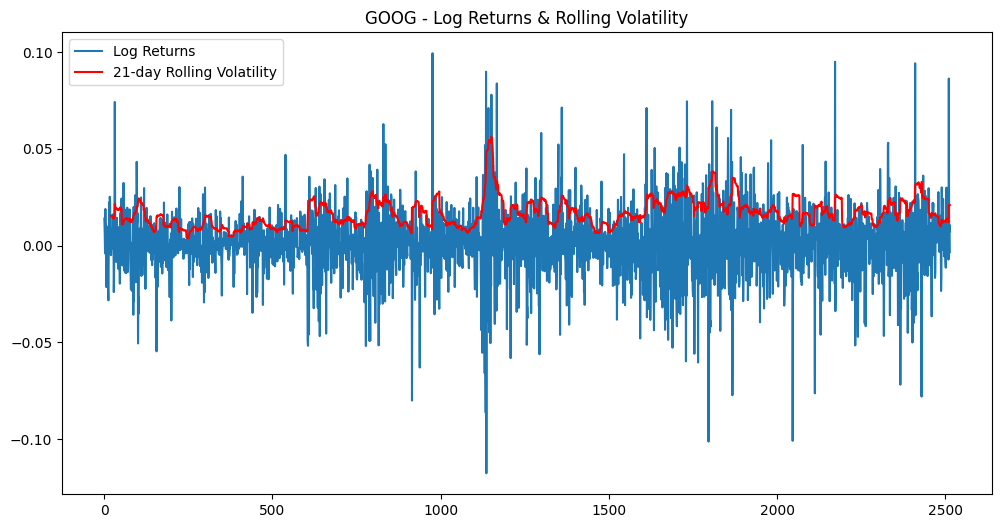

In [76]:
plt.figure(figsize=(12,6))
plt.plot(data['Log_Returns'], label='Log Returns')
plt.plot(data['Rolling_Vol'], label=f'{window}-day Rolling Volatility', color='red')
plt.legend()
plt.title(f"{ticker} - Log Returns & Rolling Volatility")
plt.show()

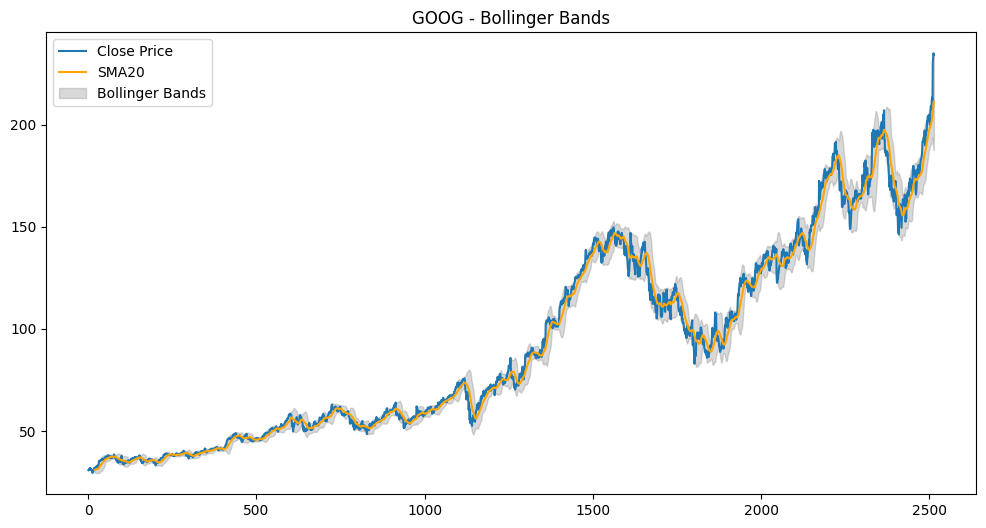

In [77]:
# bollinger bands
data['SMA20'] = data['Close'].rolling(20).mean()
data['Upper'] = data['SMA20'] + 2*data['Close'].rolling(20).std()
data['Lower'] = data['SMA20'] - 2*data['Close'].rolling(20).std()

plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['SMA20'], label='SMA20', color='orange')
plt.fill_between(data.index, data['Upper'], data['Lower'], color='gray', alpha=0.3, label='Bollinger Bands')
plt.legend()
plt.title(f"{ticker} - Bollinger Bands")
plt.show()

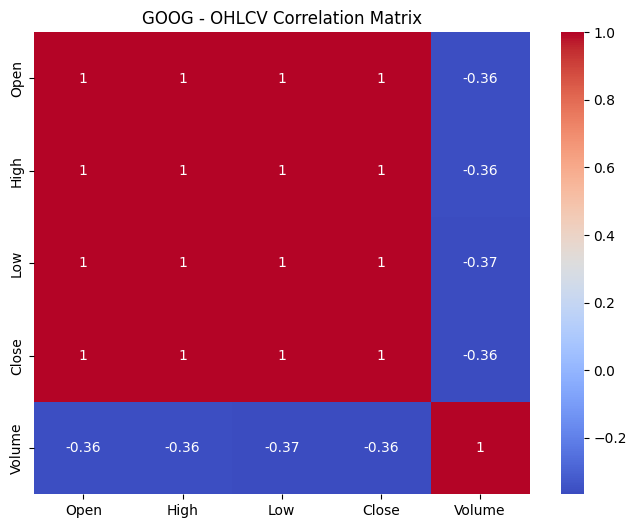

In [78]:
# correlation analysis
plt.figure(figsize=(8,6))
sns.heatmap(data[['Open','High','Low','Close','Volume']].corr(), annot=True, cmap='coolwarm')
plt.title(f"{ticker} - OHLCV Correlation Matrix")
plt.show()

In [79]:
# simple and exponential moving averages function
def add_moving_averages(data, windows=(5, 10, 20, 50, 200)):
    data = data.copy()
    for window in windows:
        # simple moving average
        data[f"SMA_{window}"] = data["Close"].rolling(window=window, min_periods=1).mean()
        
        # exponential moving average
        data[f"EMA_{window}"] = data["Close"].ewm(span=window, adjust=False).mean()
    return data